In [1]:
#############################################################################
# zlib License
#
# (C) 2023 Cristóvão Beirão da Cruz e Silva <cbeiraod@cern.ch>
#
# This software is provided 'as-is', without any express or implied
# warranty.  In no event will the authors be held liable for any damages
# arising from the use of this software.
#
# Permission is granted to anyone to use this software for any purpose,
# including commercial applications, and to alter it and redistribute it
# freely, subject to the following restrictions:
#
# 1. The origin of this software must not be misrepresented; you must not
#    claim that you wrote the original software. If you use this software
#    in a product, an acknowledgment in the product documentation would be
#    appreciated but is not required.
# 2. Altered source versions must be plainly marked as such, and must not be
#    misrepresented as being the original software.
# 3. This notice may not be removed or altered from any source distribution.
#############################################################################

#############################################################################
# Modified for ETROC2 I2C testing in jupyter notebooks, Murtaza Safdari
#############################################################################

## Imports

In [1]:
#%%
%matplotlib inline
import matplotlib.pyplot as plt
import logging
import i2c_gui
import i2c_gui.chips
from i2c_gui.usb_iss_helper import USB_ISS_Helper
from i2c_gui.fpga_eth_helper import FPGA_ETH_Helper
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
from tqdm import tqdm
from i2c_gui.chips.etroc2_chip import register_decoding
import os, sys
import multiprocessing
os.chdir('/home/daq/ETROC2/ETROC_DAQ')
import run_script
import importlib
importlib.reload(run_script)

<module 'run_script' from '/home/daq/ETROC2/ETROC_DAQ/run_script.py'>

## Set defaults

In [2]:
# 'If set, the full log will be saved to a file (i.e. the log level is ignored)'
log_file = False
# 'Set the logging level. Default: WARNING',
#  ["CRITICAL","ERROR","WARNING","INFO","DEBUG","TRACE","DETAILED_TRACE","NOTSET"]
log_level_text = "WARNING"
# 'The port name the USB-ISS module is connected to. Default: COM3'
port = "/dev/ttyACM0"
# I2C addresses for the pixel block and WS
chip_address = 0x60
ws_address = None

In [3]:
if log_file:
    logging.basicConfig(filename='logging.log', filemode='w', encoding='utf-8', level=logging.NOTSET)
    log_level = 0
else:
    log_level = 0
    if log_level_text == "CRITICAL":
        log_level=50
    elif log_level_text == "ERROR":
        log_level=40
    elif log_level_text == "WARNING":
        log_level=30
    elif log_level_text == "INFO":
        log_level=20
    elif log_level_text == "DEBUG":
        log_level=10
    elif log_level_text == "TRACE":
        log_level=8
    elif log_level_text == "DETAILED_TRACE":
        log_level=5
    elif log_level_text == "NOTSET":
        log_level=0
    logging.basicConfig(format='%(asctime)s - %(levelname)s:%(name)s:%(message)s')

i2c_gui.__no_connect__ = False  # Set to fake connecting to an ETROC2 device
i2c_gui.__no_connect_type__ = "echo"  # for actually testing readback
#i2c_gui.__no_connect_type__ = "check"  # default behaviour

## Start logger and connect

In [4]:
logger = logging.getLogger("Script_Logger")

Script_Helper = i2c_gui.ScriptHelper(logger)

## USB ISS connection
conn = i2c_gui.Connection_Controller(Script_Helper)
conn.connection_type = "USB-ISS"
conn.handle: USB_ISS_Helper
conn.handle.port = port
conn.handle.clk = 100

## For FPGA connection (not yet fully implemented)
#conn.connection_type = "FPGA-Eth"
#conn.handle: FPGA_ETH_Helper
#conn.handle.hostname = "192.168.2.3"
#conn.handle.port = "1024"

conn.connect()

In [5]:
chip = i2c_gui.chips.ETROC2_Chip(parent=Script_Helper, i2c_controller=conn)
chip.config_i2c_address(chip_address)  # Not needed if you do not access ETROC registers (i.e. only access WS registers)
# chip.config_waveform_sampler_i2c_address(ws_address)  # Not needed if you do not access WS registers

logger.setLevel(log_level)

## Useful Functions

In [6]:
def pixel_decoded_register_write(decodedRegisterName, data_to_write):
    bit_depth = register_decoding["ETROC2"]["Register Blocks"]["Pixel Config"][decodedRegisterName]["bits"]
    handle = chip.get_decoded_indexed_var("ETROC2", "Pixel Config", decodedRegisterName)
    chip.read_decoded_value("ETROC2", "Pixel Config", decodedRegisterName)
    if len(data_to_write)!=bit_depth: print("Binary data_to_write is of incorrect length for",decodedRegisterName, "with bit depth", bit_depth)
    data_hex_modified = hex(int(data_to_write, base=2))
    if(bit_depth>1): handle.set(data_hex_modified)
    elif(bit_depth==1): handle.set(data_to_write)
    else: print(decodedRegisterName, "!!!ERROR!!! Bit depth <1, how did we get here...")
    chip.write_decoded_value("ETROC2", "Pixel Config", decodedRegisterName)

def pixel_decoded_register_read(decodedRegisterName, key, need_int=False):
    handle = chip.get_decoded_indexed_var("ETROC2", f"Pixel {key}", decodedRegisterName)
    chip.read_decoded_value("ETROC2", f"Pixel {key}", decodedRegisterName)
    if(need_int): return int(handle.get(), base=16)
    else: return handle.get()

def peripheral_decoded_register_write(decodedRegisterName, data_to_write):
    bit_depth = register_decoding["ETROC2"]["Register Blocks"]["Peripheral Config"][decodedRegisterName]["bits"]
    handle = chip.get_decoded_display_var("ETROC2", "Peripheral Config", decodedRegisterName)
    chip.read_decoded_value("ETROC2", "Peripheral Config", decodedRegisterName)
    if len(data_to_write)!=bit_depth: print("Binary data_to_write is of incorrect length for",decodedRegisterName, "with bit depth", bit_depth)
    data_hex_modified = hex(int(data_to_write, base=2))
    if(bit_depth>1): handle.set(data_hex_modified)
    elif(bit_depth==1): handle.set(data_to_write)
    else: print(decodedRegisterName, "!!!ERROR!!! Bit depth <1, how did we get here...")
    chip.write_decoded_value("ETROC2", "Peripheral Config", decodedRegisterName)

def peripheral_decoded_register_read(decodedRegisterName, key, need_int=False):
    handle = chip.get_decoded_display_var("ETROC2", f"Peripheral {key}", decodedRegisterName)
    chip.read_decoded_value("ETROC2", f"Peripheral {key}", decodedRegisterName)
    if(need_int): return int(handle.get(), base=16)
    else: return handle.get()

## PIxel ID check

In [7]:
Failure_map = np.zeros((16,16))
row_indexer_handle,_,_ = chip.get_indexer("row")  # Returns 3 parameters: handle, min, max
column_indexer_handle,_,_ = chip.get_indexer("column")
for row in range(16):
    for col in range(16):
        column_indexer_handle.set(col)
        row_indexer_handle.set(row)
        fetched_row = pixel_decoded_register_read("PixelID-Row", "Status", need_int=True)
        fetched_col = pixel_decoded_register_read("PixelID-Col", "Status", need_int=True)
        if(row!=fetched_row or col!=fetched_col):
            print("Fail!", row, col, fetched_row, fetched_col)
            Failure_map[15-row,15-col] = 1

In [8]:
#%%
%matplotlib inline
import matplotlib.pyplot as plt

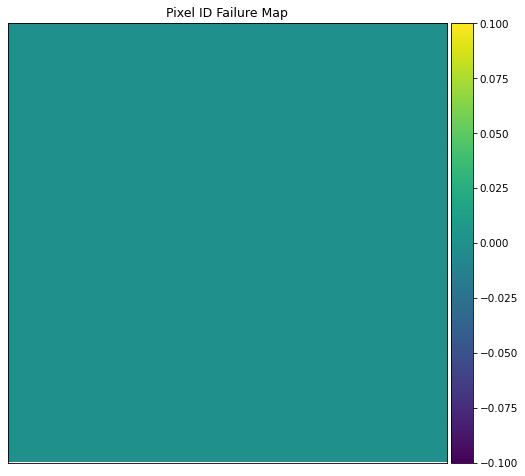

In [9]:
fig = plt.figure(dpi=75, figsize=(8,8))
gs = fig.add_gridspec(1,1)

ax0 = fig.add_subplot(gs[0,0])
ax0.set_title("Pixel ID Failure Map")
img0 = ax0.imshow(Failure_map, interpolation='none')
ax0.set_aspect("equal")
ax0.get_yaxis().set_visible(False)
ax0.get_xaxis().set_visible(False)
divider = make_axes_locatable(ax0)
cax = divider.append_axes('right', size="5%", pad=0.05)
fig.colorbar(img0, cax=cax, orientation="vertical")

plt.show()

## Set Peripheral Registers

In [10]:
peripheral_decoded_register_write("EFuse_Prog", format(0x00017f0f, '032b'))
peripheral_decoded_register_write("singlePort", '1')
peripheral_decoded_register_write("serRateLeft", '00')
peripheral_decoded_register_write("serRateRight", '00')
peripheral_decoded_register_write("onChipL1AConf", '00')
peripheral_decoded_register_write("PLL_ENABLEPLL", '1')
peripheral_decoded_register_write("chargeInjectionDelay", format(0x0a, '05b'))

In [11]:
for key in register_decoding["ETROC2"]["Register Blocks"]["Peripheral Config"].keys():
    print(key, ":", peripheral_decoded_register_read(key, "Config"))

PLLclkgen_disCLK : 0
PLLclkgen_disDES : 0
PLLclkgen_disEOM : 1
PLLclkgen_disSER : 1
PLLclkgen_disVCO : 0
CLKSel : 1
PLL_FBDiv_clkTreeDisable : 0
PLL_FBDiv_skip : 0
PLL_BiasGen_CONFIG : 0x8
PLL_CONFIG_I_PLL : 0x9
PLL_CONFIG_P_PLL : 0x9
PLL_R_CONFIG : 0x2
PLL_vcoDAC : 0x8
PLL_vcoRailMode : 1
PLL_ENABLEPLL : 1
VrefGen_PD : 0
PS_CPCurrent : 0x1
PS_CapRst : 0
PS_Enable : 1
PS_ForceDown : 0
TS_PD : 0
PS_PhaseAdj : 0x00
RefStrSel : 0x03
CLK40_EnRx : 1
CLK40_EnTer : 1
CLK40_Equ : 0x0
CLK40_InvData : 0
CLK40_SetCM : 1
GRO_Start : 0
GRO_TOARST_N : 1
CLK1280_EnRx : 1
CLK1280_EnTer : 1
CLK1280_Equ : 0x0
CLK1280_InvData : 0
CLK1280_SetCM : 1
GRO_TOA_CK : 1
GRO_TOA_Latch : 1
FC_EnRx : 1
FC_EnTer : 1
FC_Equ : 0x0
FC_InvData : 0
FC_SetCM : 1
GRO_TOTRST_N : 1
GRO_TOT_CK : 1
BCIDoffset : 0x0d0
emptySlotBCID : 0x001
readoutClockDelayPixel : 0x00
asyAlignFastcommand : 0
asyLinkReset : 0
asyPLLReset : 1
readoutClockWidthPixel : 0x10
asyResetChargeInj : 1
asyResetFastcommand : 1
asyResetGlobalReadout : 1
re

In [12]:
row_indexer_handle,_,_ = chip.get_indexer("row")
column_indexer_handle,_,_ = chip.get_indexer("column")

column_indexer_handle.set(0)
row_indexer_handle.set(0)

for key in register_decoding["ETROC2"]["Register Blocks"]["Pixel Config"].keys():
    print(key, ":", pixel_decoded_register_read(key, "Config"))

for key in register_decoding["ETROC2"]["Register Blocks"]["Pixel Status"].keys():
    print(key, ":", pixel_decoded_register_read(key, "Status"))

CLSel : 0x0
IBSel : 0x7
RFSel : 0x2
HysSel : 0xf
PD_DACDiscri : 0
QSel : 0x0e
QInjEn : 0
autoReset_TDC : 0
enable_TDC : 1
level_TDC : 0x1
resetn_TDC : 1
testMode_TDC : 0
Bypass_THCal : 0
DAC : 0x000
TH_offset : 0x07
RSTn_THCal : 1
ScanStart_THCal : 0
BufEn_THCal : 0
CLKEn_THCal : 0
workMode : 0x0
L1Adelay : 0x1f5
disDataReadout : 1
disTrigPath : 0
upperTOATrig : 0x200
lowerTOATrig : 0x020
upperTOTTrig : 0x040
lowerTOTTrig : 0x010
upperCalTrig : 0x200
lowerCalTrig : 0x010
upperTOA : 0x200
lowerTOA : 0x020
upperTOT : 0x100
lowerTOT : 0x010
upperCal : 0x200
lowerCal : 0x010
addrOffset : 1
selfTestOccupancy : 0x01
ACC : 0x0000
ScanDone : 1
BL : 0x0f6
NW : 0x3
TH : 0x0fd
THState : 0x6
PixelID : 0x00
PixelID-Col : 0x0
PixelID-Row : 0x0


## Reset Chip O/P

In [24]:
# Reset output, active low
peripheral_decoded_register_write("asyResetGlobalReadout", '0')
peripheral_decoded_register_write("asyResetGlobalReadout", '1')

## LINK RESET

In [20]:
peripheral_decoded_register_write("asyLinkReset", '1')

In [21]:
## Low for real data
peripheral_decoded_register_write("asyLinkReset", '0')

## Auto-calibrate all pixels

In [13]:
BL_map_THCal = np.zeros((16,16))
NW_map_THCal = np.zeros((16,16))

In [18]:
row_indexer_handle,_,_ = chip.get_indexer("row")  # Returns 3 parameters: handle, min, max
column_indexer_handle,_,_ = chip.get_indexer("column")
column_indexer_handle.set(0)
row_indexer_handle.set(0)

broadcast_handle,_,_ = chip.get_indexer("broadcast")
# Enable THCal clock and buffer, disable bypass
broadcast_handle.set(True)
pixel_decoded_register_write("CLKEn_THCal", "1")
broadcast_handle.set(True)
pixel_decoded_register_write("BufEn_THCal", "1")
broadcast_handle.set(True)
pixel_decoded_register_write("Bypass_THCal", "0")
broadcast_handle.set(True)
pixel_decoded_register_write("TH_offset", format(0x07, '06b'))
# Reset the calibration block (active low)
broadcast_handle.set(True)
pixel_decoded_register_write("RSTn_THCal", "0")
time.sleep(1)
broadcast_handle.set(True)
pixel_decoded_register_write("RSTn_THCal", "1")
# Start and Stop the calibration, (25ns x 2**15 ~ 800 us, ACCumulator max is 2**15)
broadcast_handle.set(True)
pixel_decoded_register_write("ScanStart_THCal", "1")
time.sleep(4)
broadcast_handle.set(True)
pixel_decoded_register_write("ScanStart_THCal", "0")
# Disable clock and buffer before charge injection 
broadcast_handle.set(True)
pixel_decoded_register_write("CLKEn_THCal", "0") 
broadcast_handle.set(True)
pixel_decoded_register_write("BufEn_THCal", "0")
# Set Charge Inj Q to 15 fC
broadcast_handle.set(True)
pixel_decoded_register_write("QSel", format(0x0e, '05b'))

# Loop for fetching calibrated values
for row in tqdm(range(16), desc=" row", position=0):
    for col in tqdm(range(16), desc=" col", position=1, leave=False):
# for index,row,col in zip(tqdm(range(16)), row_list, col_list):
        column_indexer_handle.set(col)
        row_indexer_handle.set(row)
        # Check the calibration done correctly
        if(pixel_decoded_register_read("ScanDone", "Status")!="1"): print("!!!ERROR!!! Scan not done!!!")
        BL_map_THCal[row, col] = pixel_decoded_register_read("BL", "Status", need_int=True)
        NW_map_THCal[row, col] = pixel_decoded_register_read("NW", "Status", need_int=True)
        

 row: 100%|██████████| 16/16 [00:12<00:00,  1.28it/s]


In [29]:
row_indexer_handle,_,_ = chip.get_indexer("row")  # Returns 3 parameters: handle, min, max
column_indexer_handle,_,_ = chip.get_indexer("column")
# Loop for threshold calibration
for row in tqdm(range(16), desc=" row", position=0):
    for col in tqdm(range(16), desc=" col", position=1, leave=False):
# for index,row,col in zip(tqdm(range(16)), row_list, col_list):
        column_indexer_handle.set(col)
        row_indexer_handle.set(row)
        # Maybe required to make this work
        # pixel_decoded_register_write("enable_TDC", "0")
        # pixel_decoded_register_write("testMode_TDC", "0")
        # Enable THCal clock and buffer, disable bypass
        pixel_decoded_register_write("CLKEn_THCal", "1")
        pixel_decoded_register_write("BufEn_THCal", "1")
        pixel_decoded_register_write("Bypass_THCal", "0")
        pixel_decoded_register_write("TH_offset", format(0x07, '06b'))
        # Reset the calibration block (active low)
        pixel_decoded_register_write("RSTn_THCal", "0")
        pixel_decoded_register_write("RSTn_THCal", "1")
        # Start and Stop the calibration, (25ns x 2**15 ~ 800 us, ACCumulator max is 2**15)
        pixel_decoded_register_write("ScanStart_THCal", "1")
        pixel_decoded_register_write("ScanStart_THCal", "0")
        # Check the calibration done correctly
        if(pixel_decoded_register_read("ScanDone", "Status")!="1"): print("!!!ERROR!!! Scan not done!!!")
        BL_map_THCal[row, col] = pixel_decoded_register_read("BL", "Status", need_int=True)
        NW_map_THCal[row, col] = pixel_decoded_register_read("NW", "Status", need_int=True)
        # Disable clock and buffer before charge injection 
        pixel_decoded_register_write("CLKEn_THCal", "0") 
        pixel_decoded_register_write("BufEn_THCal", "0")
        # Set Charge Inj Q to 15 fC
        pixel_decoded_register_write("QSel", format(0x0e, '05b'))

 row: 100%|██████████| 16/16 [01:45<00:00,  6.58s/it]


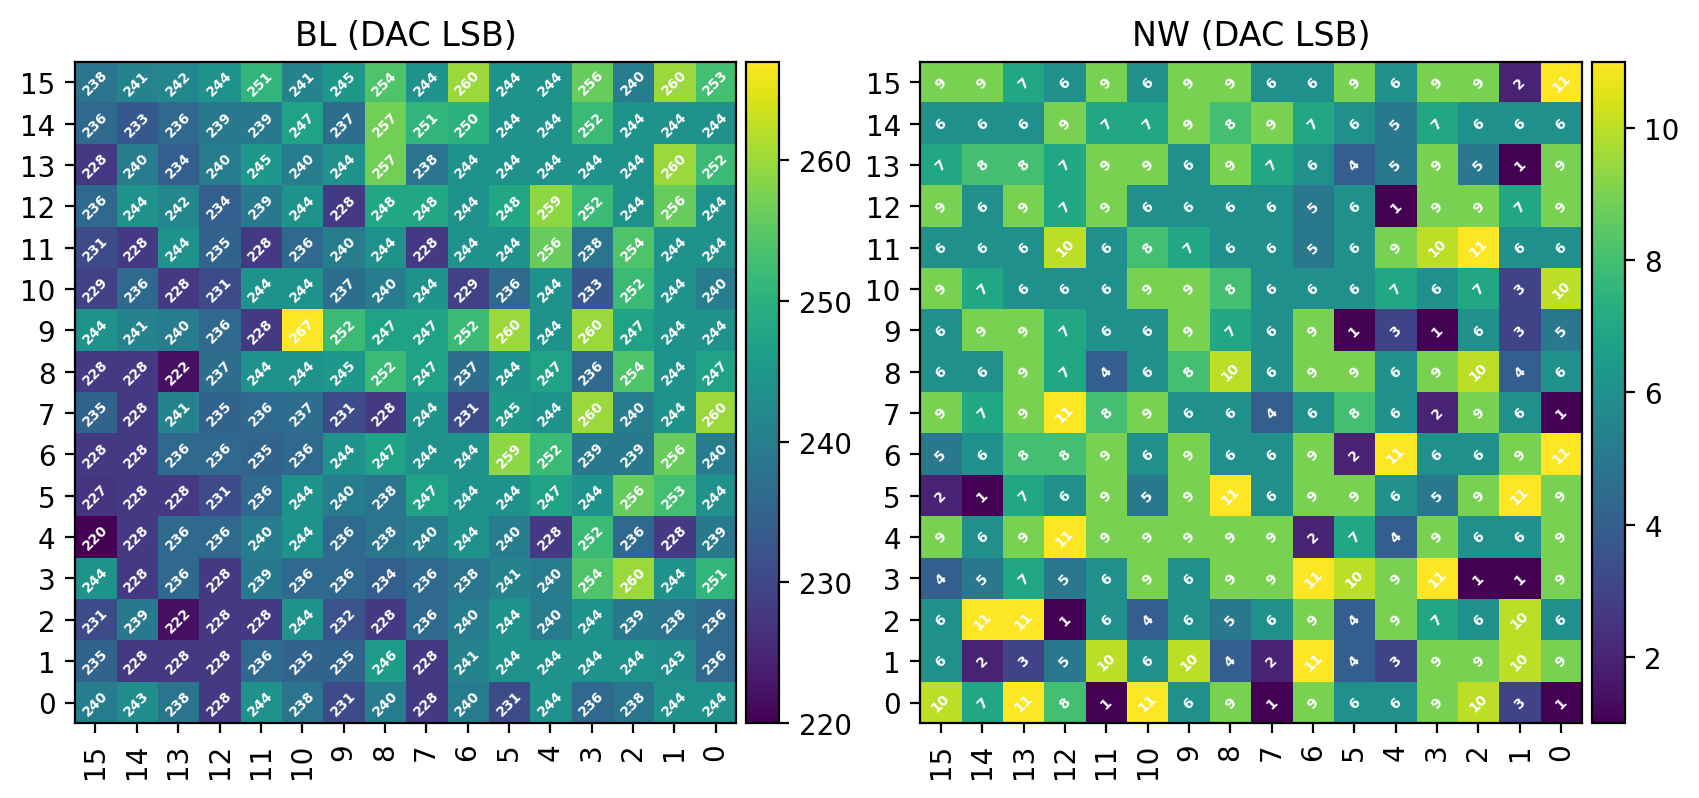

In [19]:
fig = plt.figure(dpi=200, figsize=(10,10))
gs = fig.add_gridspec(1,2)

ax0 = fig.add_subplot(gs[0,0])
ax0.set_title("BL (DAC LSB)")
img0 = ax0.imshow(BL_map_THCal, interpolation='none')
ax0.set_aspect("equal")
ax0.invert_xaxis()
ax0.invert_yaxis()
plt.xticks(range(16), range(16), rotation="vertical")
plt.yticks(range(16), range(16))
divider = make_axes_locatable(ax0)
cax = divider.append_axes('right', size="5%", pad=0.05)
fig.colorbar(img0, cax=cax, orientation="vertical")

ax1 = fig.add_subplot(gs[0,1])
ax1.set_title("NW (DAC LSB)")
img1 = ax1.imshow(NW_map_THCal, interpolation='none')
ax1.set_aspect("equal")
ax1.invert_xaxis()
ax1.invert_yaxis()
plt.xticks(range(16), range(16), rotation="vertical")
plt.yticks(range(16), range(16))
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size="5%", pad=0.05)
fig.colorbar(img1, cax=cax, orientation="vertical")

for x in range(16):
    for y in range(16):
        # if(BL_map_THCal.T[x,y]==0): continue
        ax0.text(x,y,f"{BL_map_THCal.T[x,y]:.0f}", c="white", size=5, rotation=45, fontweight="bold", ha="center", va="center")
        ax1.text(x,y,f"{NW_map_THCal.T[x,y]:.0f}", c="white", size=5, rotation=45, fontweight="bold", ha="center", va="center")

#plt.show()

## Automatic pixel charge injection

### Disable all pixels

In [35]:
row_indexer_handle,_,_ = chip.get_indexer("row")
column_indexer_handle,_,_ = chip.get_indexer("column")
column_indexer_handle.set(0)
row_indexer_handle.set(0)

broadcast_handle,_,_ = chip.get_indexer("broadcast")
broadcast_handle.set(True)
pixel_decoded_register_write("disDataReadout", "1")
broadcast_handle.set(True)
pixel_decoded_register_write("QInjEn", "0")

### Define pixels of interest

In [39]:
# Diagnoal scan
# col_list = list(np.arange(16)[1:-1]) + list(np.arange(16)[1:-1])
# row_list = list(np.arange(16)[1:-1]) + list(np.arange(16)[::-1][1:-1])

# Box scan
# col_list = list(np.arange(16)[0:-1]) + list(np.full(15, 15)) + list(np.arange(16)[1:]) + list(np.full(15, 0))
# row_list = list(np.full(15, 0)) + list(np.arange(16)[0:-1]) + list(np.full(15, 15)) + list(np.arange(16)[1:])

# Cluster scan
# col_list = [3, 3, 3, 12, 12, 12]
# row_list = [3, 8, 13, 3, 8, 13]

# row_list = list(np.arange(4)[0:])
# col_list = np.zeros_like(row_list)
row_list = [3]
col_list = [3]

In [40]:
print(list(zip(col_list, row_list)))
# print(col_list)
# print(row_list)

[(3, 3)]


### Enable and Disable Qinj runs


#### Single Pixel Testing

Enable

In [12]:
row_indexer_handle,_,_ = chip.get_indexer("row")  # Returns 3 parameters: handle, min, max
column_indexer_handle,_,_ = chip.get_indexer("column")
row = 7
col = 7
column_indexer_handle.set(col)
row_indexer_handle.set(row)
# pixel_decoded_register_write("TH_offset", format(0x0c, '06b'))
# pixel_decoded_register_write("L1Adelay", format(0x1f5, '09b'))
# pixel_decoded_register_write("QSel", format(0x0e, '05b'))
pixel_decoded_register_write("disDataReadout", "0")
pixel_decoded_register_write("QInjEn", "1")

Disable

In [19]:
row_indexer_handle,_,_ = chip.get_indexer("row")  # Returns 3 parameters: handle, min, max
column_indexer_handle,_,_ = chip.get_indexer("column")
row = 7
col = 7
column_indexer_handle.set(col)
row_indexer_handle.set(row)
pixel_decoded_register_write("QInjEn", "0")
pixel_decoded_register_write("disDataReadout", "1")

Data Acquisition

In [ ]:
parser = run_script.getOptionParser()
(options, args) = parser.parse_args(args="--useIPC --hostname 192.168.2.3 -t 60 -o test8 -v -w".split())
IPC_queue = multiprocessing.Queue()
process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options))
process.start()

In [ ]:
IPC_queue.put('start DAQ')

In [ ]:
IPC_queue.put('start L1A train')

In [ ]:
IPC_queue.put('start L1A')

In [ ]:
IPC_queue.put('stop L1A')

In [ ]:
IPC_queue.put('stop L1A train')

In [ ]:
IPC_queue.put('link reset')

In [ ]:
IPC_queue.put('allow threads to exit')
process.join()

#### Mutliple Pixel Testing

In [29]:
scan_name = "E2_testing_VRef_Qinj_CB_RB"
total_number_pixels = len(row_list)
time_per_pixel = 30
dead_time_per_pixel = 5
total_scan_time = total_number_pixels*(time_per_pixel + dead_time_per_pixel) + 10
print(f"Scanning {total_number_pixels} pixels for a total of {total_scan_time} s")

row_indexer_handle,_,_ = chip.get_indexer("row")  # Returns 3 parameters: handle, min, max
column_indexer_handle,_,_ = chip.get_indexer("column")

parser = run_script.getOptionParser()
(options, args) = parser.parse_args(args=f"--useIPC --hostname 192.168.2.3 -t {int(total_scan_time)} -o {scan_name} -v -w --compressed_translation".split())

IPC_queue = multiprocessing.Queue()
process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, 'main_process'))
process.start()

# Loop for enable/disable charge injection per pixel (single!!!)
for index, row, col in zip(tqdm(range(len(row_list))), row_list, col_list):
    column_indexer_handle.set(col)
    row_indexer_handle.set(row)
    # Modifying charge injected
    # pixel_decoded_register_write("QSel", format(0x0e, '05b'))
    # Enable charge injection
    pixel_decoded_register_write("disDataReadout", "0")
    pixel_decoded_register_write("QInjEn", "1")
    time.sleep(1)
    IPC_queue.put('start L1A train')
    while not IPC_queue.empty():
        pass
    # DAQ time
    time.sleep(time_per_pixel)
    IPC_queue.put('stop L1A train')
    while not IPC_queue.empty():
        pass
    time.sleep(1)
    # Disable charge injection
    pixel_decoded_register_write("QInjEn", "0")
    pixel_decoded_register_write("disDataReadout", "1")
    time.sleep(1)

IPC_queue.put('allow threads to exit')
process.join()

Scanning 60 pixels for a total of 2110 s


100%|██████████| 60/60 [33:09<00:00, 33.17s/it]


#### Cluster Pixel Testing (3x3 grid centered at pixels)

Qinj only for the central Pixels

In [38]:
sub_col_list = [-1, 0, 1,-1, 0, 1,-1, 1]
sub_row_list = [-1,-1,-1, 1, 1, 1, 0, 0]

scan_name = "E2_testing_VRef_Qinj_Cluster_Single_test"
total_number_pixels = len(row_list)
time_per_pixel = 60
dead_time_per_pixel = 5
total_scan_time = total_number_pixels*(time_per_pixel + dead_time_per_pixel) + 10
print(f"Scanning {total_number_pixels} pixels for a total of {total_scan_time} s")

row_indexer_handle,_,_ = chip.get_indexer("row")
column_indexer_handle,_,_ = chip.get_indexer("column")

parser = run_script.getOptionParser()
(options, args) = parser.parse_args(args=f"--useIPC --hostname 192.168.2.3 -t {int(total_scan_time)} -o {scan_name} -v -w --compressed_translation".split())

IPC_queue = multiprocessing.Queue()
process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, 'main_process'))
process.start()

# Loop for enable/disable charge injection per pixel cluster
for index, row, col in zip(tqdm(range(len(row_list)), desc="parent", position=0), row_list, col_list):
    column_indexer_handle.set(col)
    row_indexer_handle.set(row)
    # Modifying charge injected
    # pixel_decoded_register_write("QSel", format(0x0e, '05b'))
    # Enable charge injection
    pixel_decoded_register_write("disDataReadout", "0")
    pixel_decoded_register_write("QInjEn", "1")
    for sub_index, sub_row, sub_col in zip(tqdm(range(len(sub_row_list)), desc="child1", position=1, leave=False), sub_row_list, sub_col_list):
        if(col+sub_col>15 or col+sub_col<0 or row+sub_row>15 or row+sub_row<0): 
            print(col+sub_col,",",row+sub_row," (COL,ROW) sub pixel is illegal")
            continue
        column_indexer_handle.set(col+sub_col)
        row_indexer_handle.set(row+sub_row)
        # Enable readout only
        pixel_decoded_register_write("disDataReadout", "0")
        pixel_decoded_register_write("QInjEn", "0")
    column_indexer_handle.set(col)
    row_indexer_handle.set(row)
    time.sleep(1)
    IPC_queue.put('start L1A train')
    while not IPC_queue.empty():
        pass
    # DAQ time
    time.sleep(time_per_pixel)
    IPC_queue.put('stop L1A train')
    while not IPC_queue.empty():
        pass
    time.sleep(1)
    # Disable charge injection
    pixel_decoded_register_write("QInjEn", "0")
    pixel_decoded_register_write("disDataReadout", "1")
    for sub_index, sub_row, sub_col in zip(tqdm(range(len(sub_row_list)), desc="child2", position=1, leave=False), sub_row_list, sub_col_list):
        if(col+sub_col>15 or col+sub_col<0 or row+sub_row>15 or row+sub_row<0): 
            print(col+sub_col,",",row+sub_row," (COL,ROW) sub pixel is illegal")
            continue
        column_indexer_handle.set(col+sub_col)
        row_indexer_handle.set(row+sub_row)
        # Disable readout only
        pixel_decoded_register_write("disDataReadout", "1")
    time.sleep(1)

IPC_queue.put('allow threads to exit')
process.join()

del sub_col_list, sub_row_list

Scanning 6 pixels for a total of 400 s


parent: 100%|██████████| 6/6 [06:24<00:00, 64.00s/it]


Qinj equally on for all 3x3 pixels

Qinj unequally on for all 3x3 pixels

## Disconnect I2C

In [20]:
conn.disconnect()